In [1]:
import cv2
import torch
import predict
import numpy as np
from matplotlib import pyplot as plt
from pytorch_grad_cam.utils.image import show_cam_on_image
from prep import preprocess_image, mask_img_to_mask, calculate_slice_bboxes, img_resize

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [22]:
def predict_mask(model, img):
    
    image_tensor = preprocess_image(img,)
    
    pred_mask = model(image_tensor.to(device))
    pred_mask = torch.nn.functional.softmax(pred_mask, dim=1)
    pred_mask = np.transpose(pred_mask.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
    
    return pred_mask

In [3]:
image = cv2.imread('images/img/' + str('00.png'))

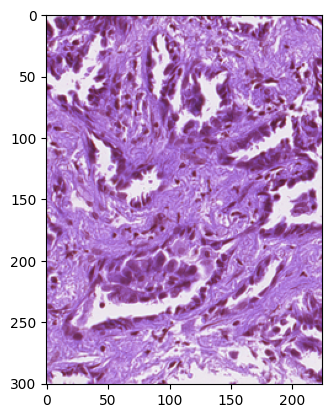

In [5]:
plt.imshow(image)

In [3]:
model = predict.load_model()

In [1]:
import torch
#model = torch.load('models/deeplabv3plus_dJ_par_resnet50_01.pth', map_location=device)

In [4]:
torch.save(model, 'models/deeplab.pth')

In [4]:
model = torch.load('models/deeplab.pth', map_location=device)

In [9]:
img_path  = 'images/img/' + str('00.png')
mask_path = 'images/mask/' + str('00.png')
bg_path   = 'images/background-mask/' + str('00.png')

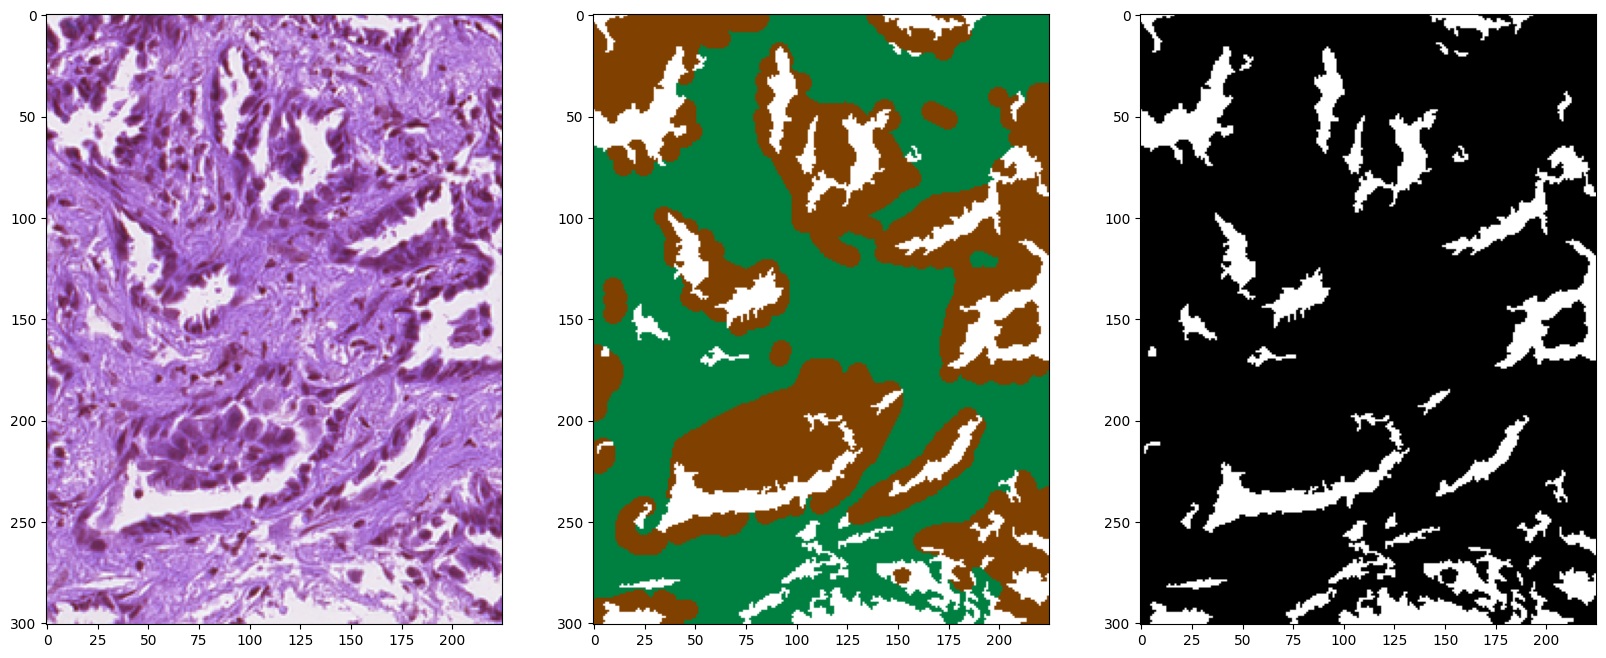

In [10]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 3, 1)
plt.imshow(cv2.imread(img_path))

ax = fig.add_subplot(1, 3, 2)
plt.imshow(cv2.imread(mask_path))

ax = fig.add_subplot(1, 3, 3)
plt.imshow(cv2.imread(bg_path))

In [12]:
img     = cv2.imread(img_path)
gt_mask = mask_img_to_mask(mask_path, bg_path)

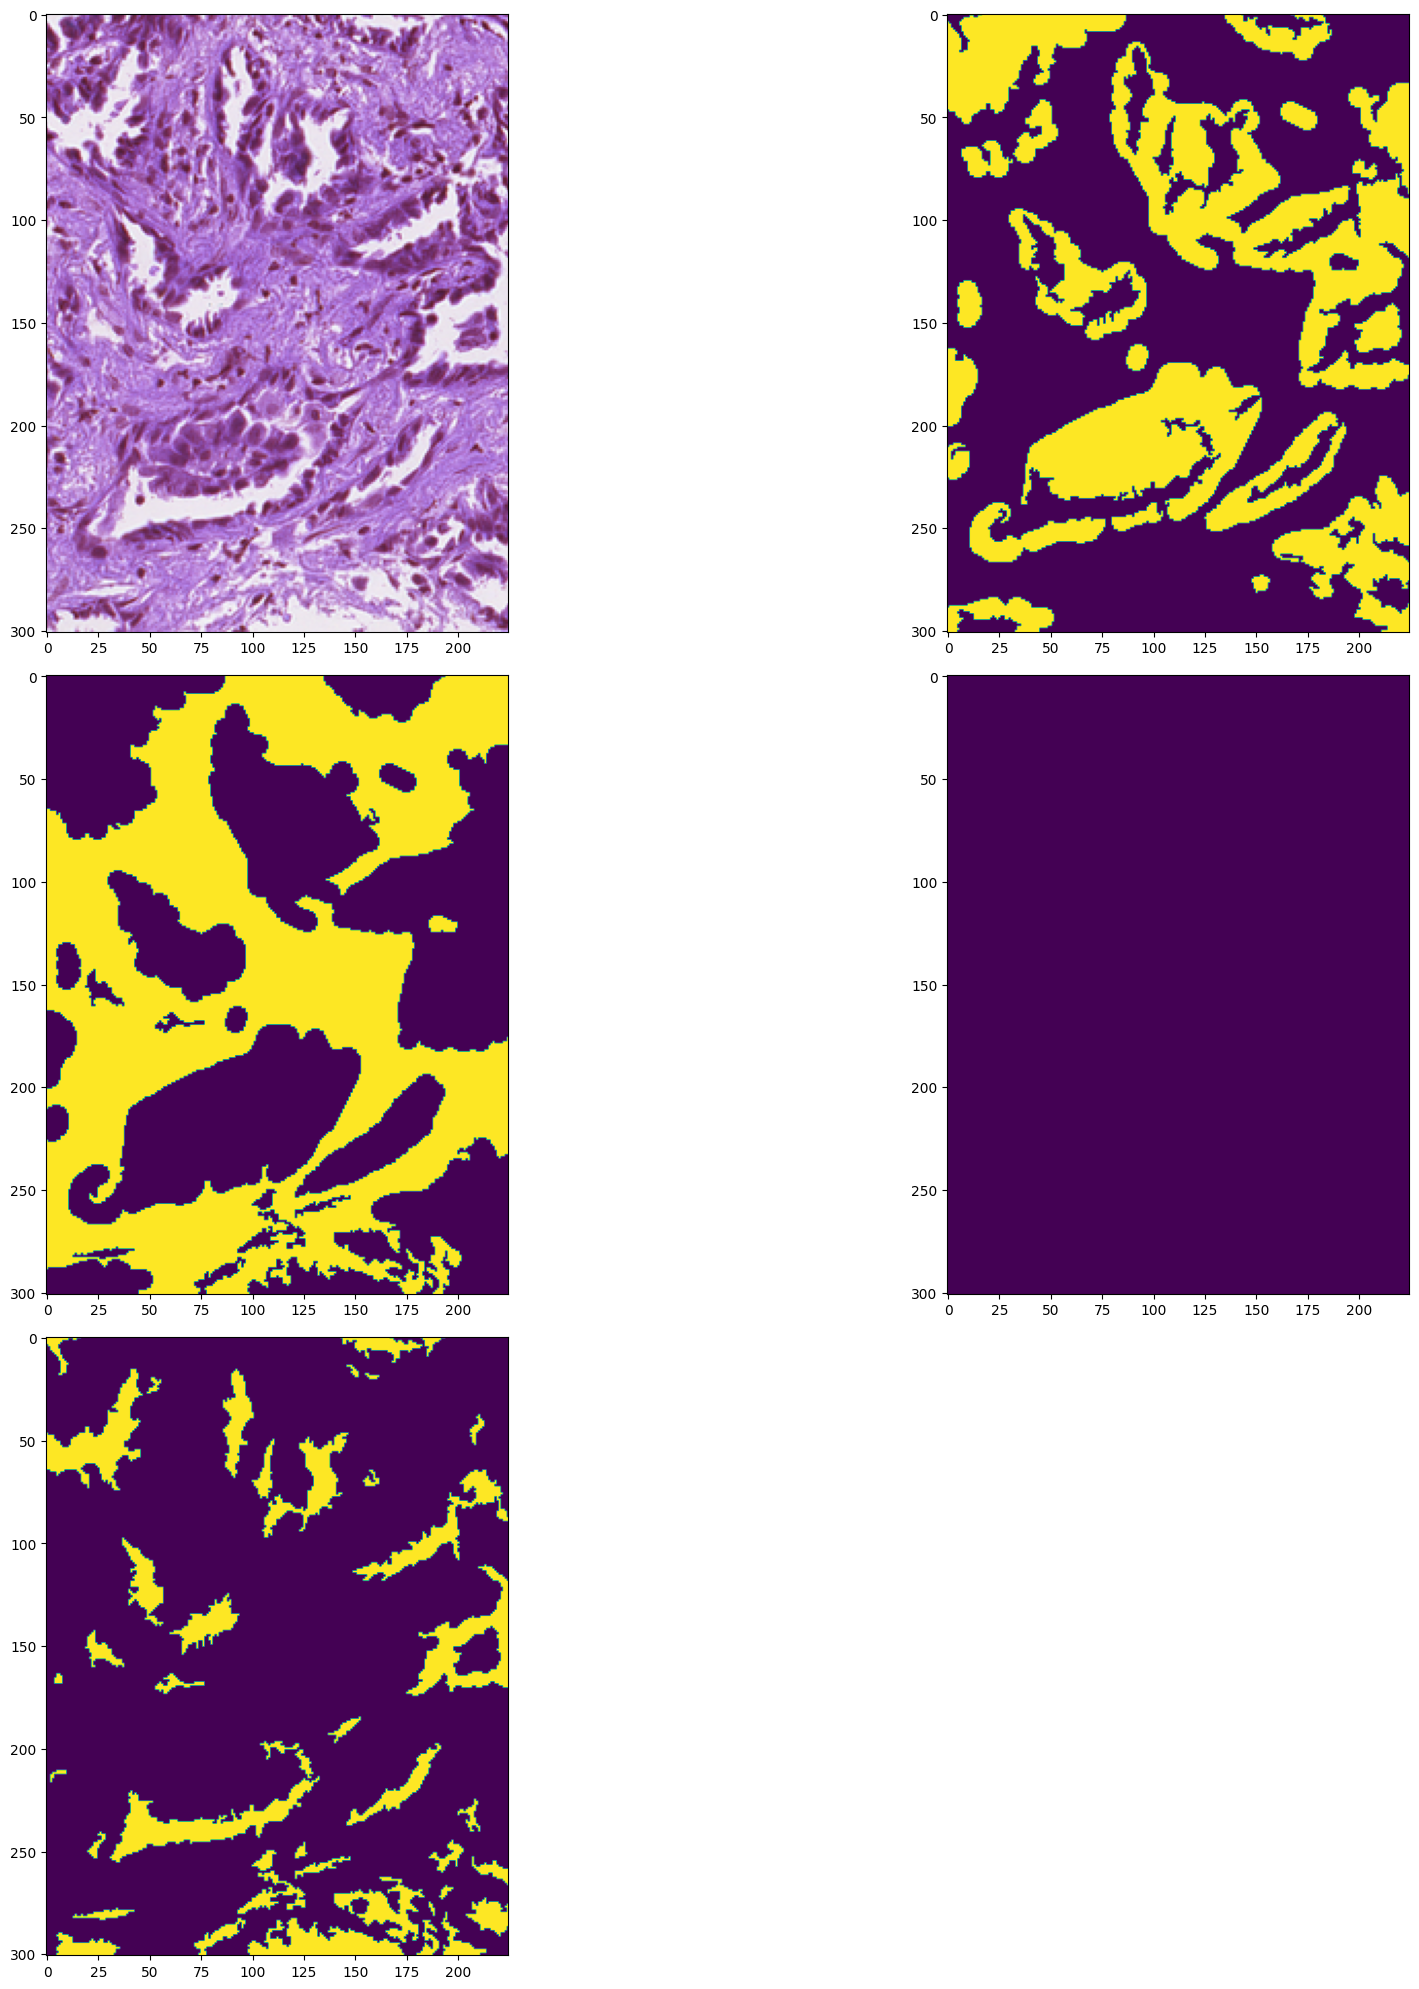

In [16]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(3, 2, 1)
plt.imshow(img)

ax = fig.add_subplot(3, 2, 2)
plt.imshow(gt_mask[:, :, 0])

ax = fig.add_subplot(3, 2, 3)
plt.imshow(gt_mask[:, :, 1])

ax = fig.add_subplot(3, 2, 4)
plt.imshow(gt_mask[:, :, 2])

ax = fig.add_subplot(3, 2, 5)
plt.imshow(gt_mask[:, :, 3])

fig.tight_layout()

In [14]:
gt_mask.shape

(301, 225, 4)

In [18]:
img, gt_mask, slice_boxes = img_resize(img, gt_mask, 224)
pred = np.zeros(gt_mask.shape)

In [19]:
slice_boxes

[[0, 0, 224, 224]]

In [28]:
for j in slice_boxes:
    pred[j[1]:j[3], j[0]:j[2]] = predict_mask(model, img[j[1]:j[3], j[0]:j[2]])

c:\Users\hamma\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [29]:
pred = pred.round().astype('uint8')

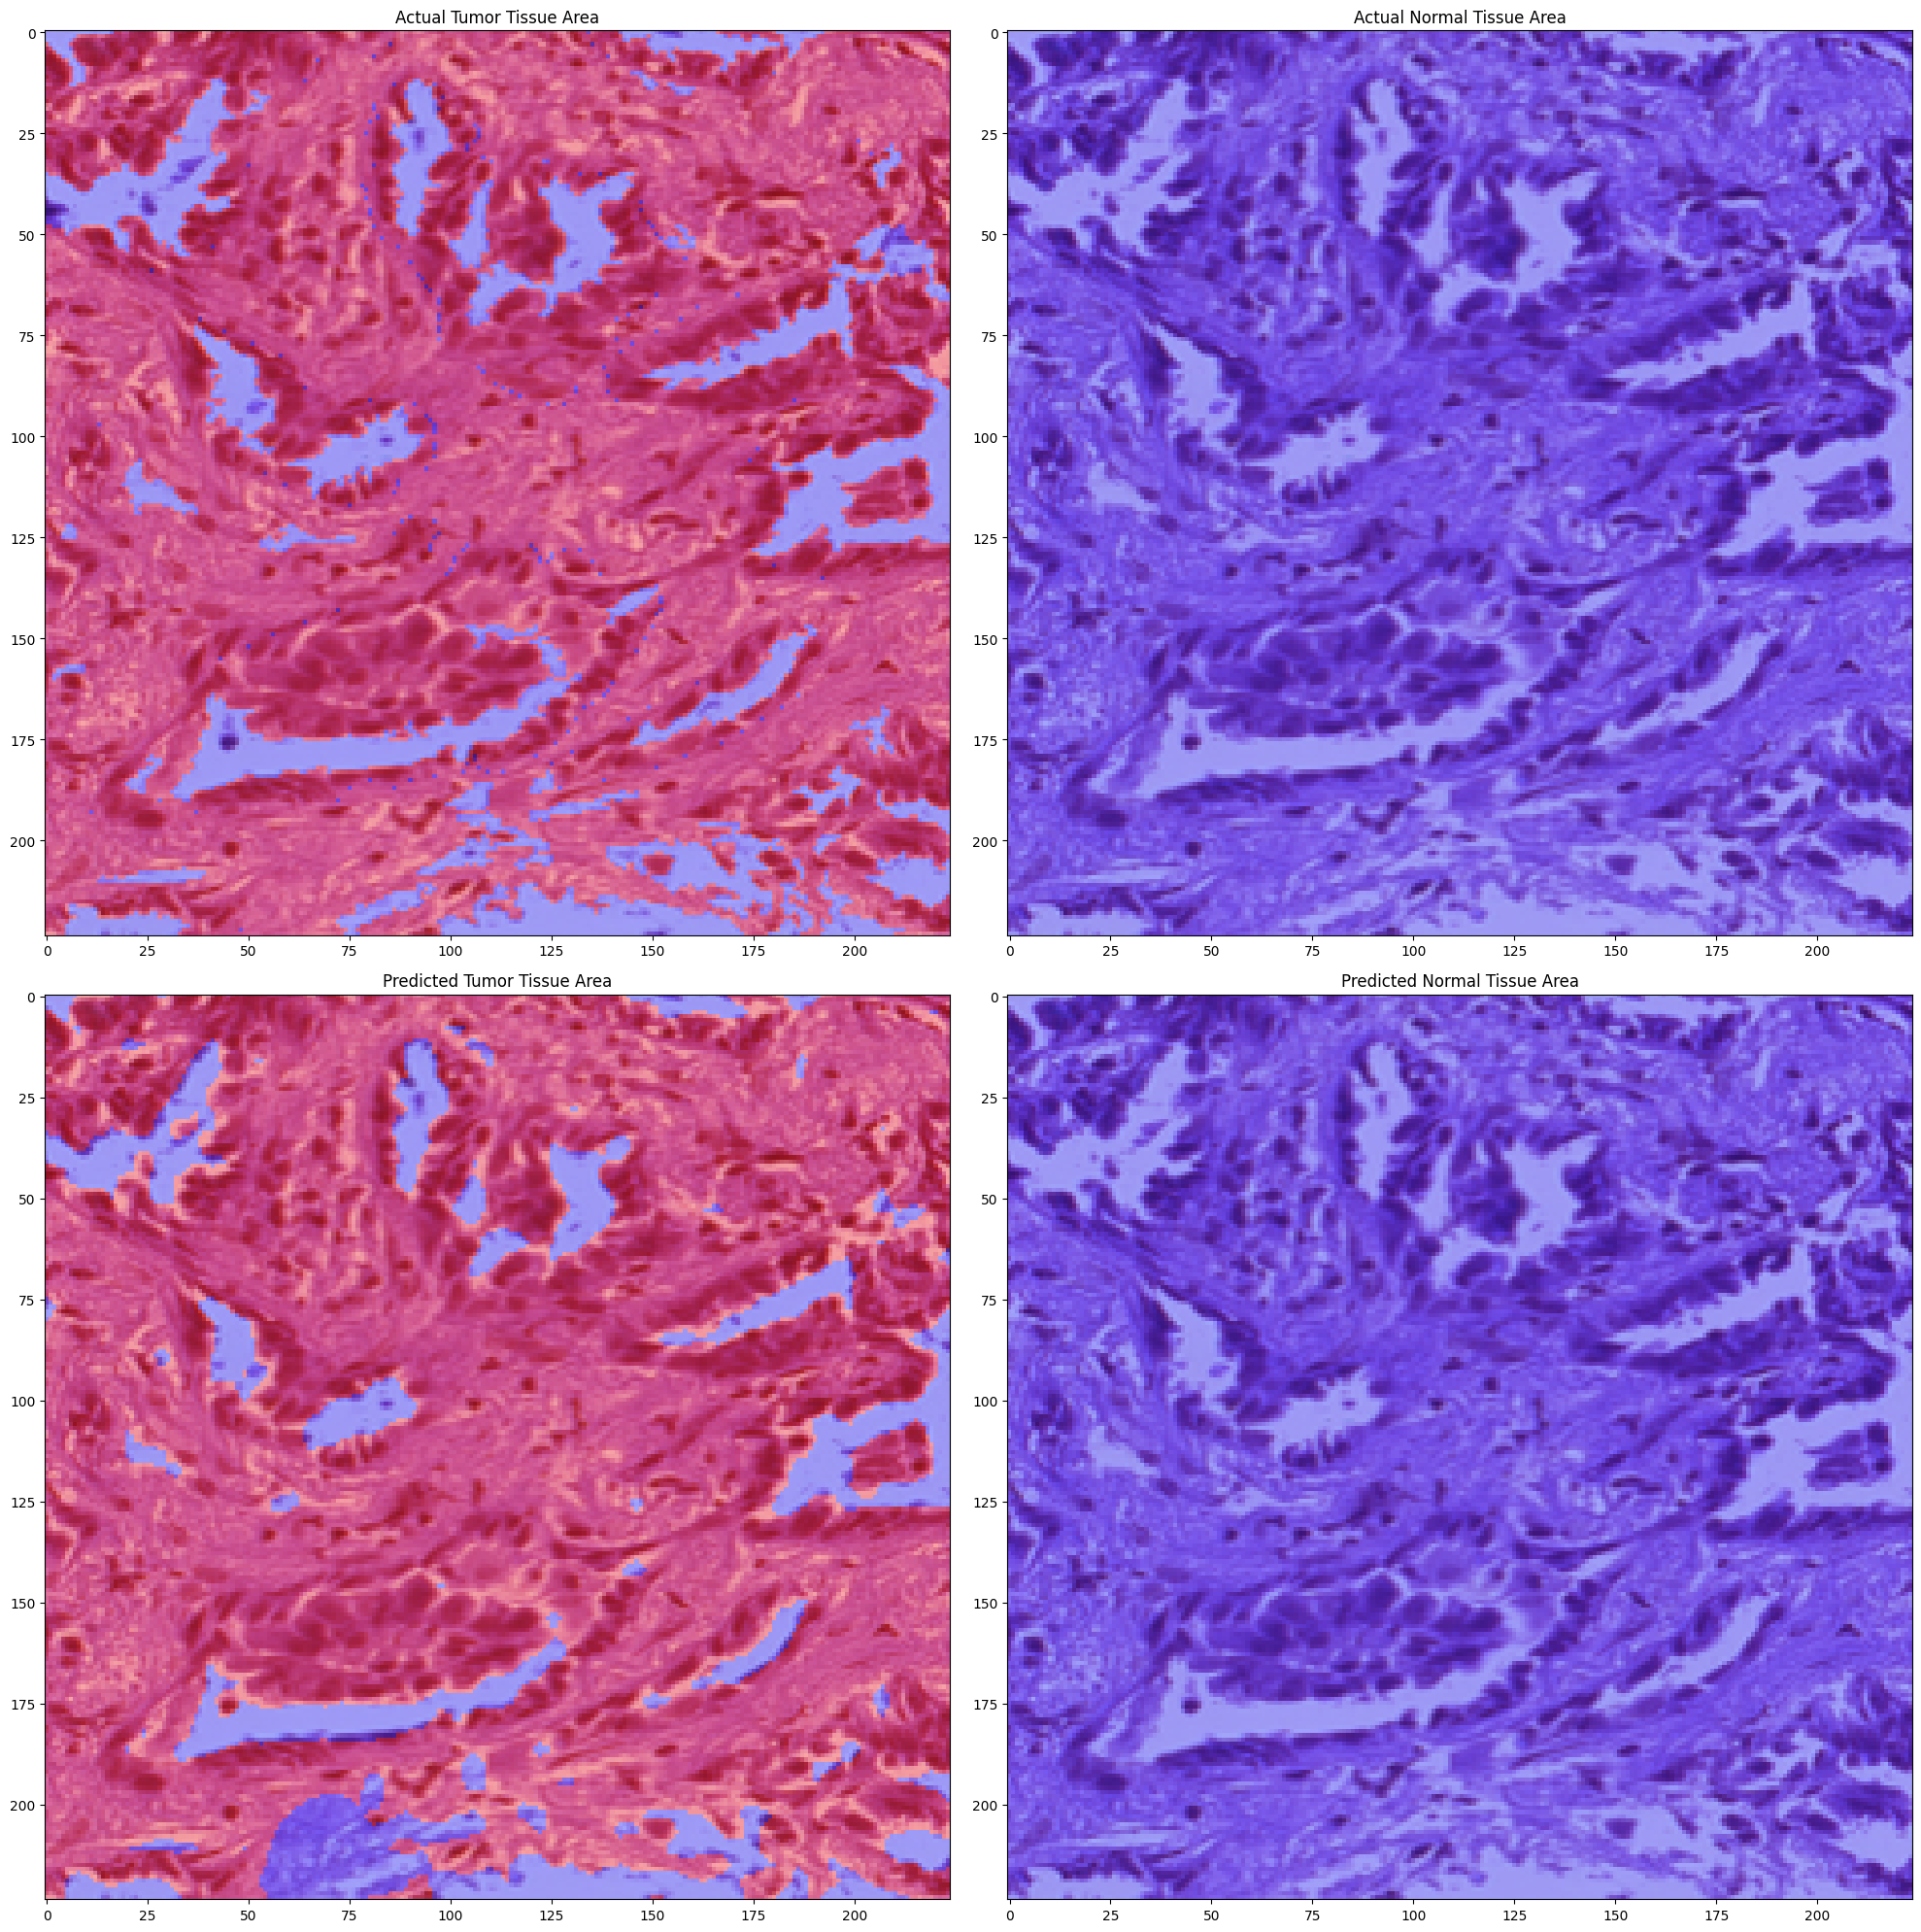

In [31]:
gt_t = (gt_mask[:, :, 0] + gt_mask[:, :, 1])
gt_t[gt_t>1] = 1
pred_t = (pred[:, :, 0] + pred[:, :, 1])
pred_t[pred_t>1] = 1

fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(2, 2, 1)
plt.imshow(show_cam_on_image(img/255, gt_t, use_rgb=True))
plt.title("Actual Tumor Tissue Area")

ax = fig.add_subplot(2, 2, 2)
plt.imshow(show_cam_on_image(img/255, gt_mask[:, :, 2], use_rgb=True))
plt.title("Actual Normal Tissue Area")

ax = fig.add_subplot(2, 2, 3)
plt.imshow(show_cam_on_image(img/255, pred_t, use_rgb=True))
plt.title("Predicted Tumor Tissue Area")

ax = fig.add_subplot(2, 2, 4)
plt.imshow(show_cam_on_image(img/255, pred[:, :, 2], use_rgb=True))
plt.title("Predicted Normal Tissue Area")

fig.tight_layout()